In [1]:
# This version of code is just a small test 
# without any CNN, but firstly use a flatten input and DNN
# to simply verify the performance of current (big) dataset

import torch
from torch import nn
import numpy as np
import pandas as pd
import h5py


In [10]:
def try_gpu(i=0):  #@save
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]


In [ ]:
# check device 

print('torch version: ', torch.__version__)
print('CUDA version: ', torch.version.cuda)
print('CUDA available: ', torch.cuda.is_available())
print('Total number of available GPU: ', torch.cuda.device_count())

torch version:  2.7.1+cu118
CUDA version:  11.8
CUDA available:  True
Total number of available GPU:  1


In [ ]:
# load path

dataset_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/data_gen/data/noisy_data/training_set.h5"
validate_data_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/data_pre_processing/data/meas_data.csv"

In [ ]:
# load data

with h5py.File(dataset_path, 'r') as f:
    print(f.keys())
    print(f['X'].shape)
    print(f['Y'].shape)

<KeysViewHDF5 ['X', 'Y']>
(10000, 2, 6, 121)
(10000, 11, 1)


In [2]:
path_original_data = 'E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/data_gen/data/dataset_process_1.h5'
path_noise_data = 'E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/data_gen/data/noisy_data/training_set.h5'
path_7row_noise_data = 'E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/data_gen/data/noisy_data/train_dataset_7row.h5'

path_7row_meas_data = 'E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/data_pre_processing/data/meas_file_reshape_7row.h5'

with h5py.File(path_original_data, 'r') as f:
    print(f.keys())
    print(f['X_gm'].shape)
    print(f['X_iv'].shape)
    print(f['Y'].shape)

with h5py.File(path_noise_data, 'r') as f:
    print(f.keys())
    print(f['X'].shape)

with h5py.File(path_7row_noise_data , 'r') as f:
    print(f.keys())
    print(f['X'].shape)

with h5py.File(path_7row_meas_data , 'r') as f:
    print(f.keys())
    print(f['X'].shape)



<KeysViewHDF5 ['X_gm', 'X_iv', 'Y']>
(1000, 121, 6)
(1000, 7, 121)
(1000, 11, 1)
<KeysViewHDF5 ['X', 'Y']>
(10000, 2, 6, 121)
<KeysViewHDF5 ['X', 'Y']>
(10000, 7, 121)
<KeysViewHDF5 ['X']>
(7, 121)


In [ ]:
def param_random_generator(param_range: dict):
    ''' generate a random parameter set for the HEMT model '''
    # generate random parameters
    var_dict = {key: str(np.random.uniform(low=val[0], high=val[1])) for key, val in param_range.items()}
    return var_dict

param_range = {
    'VOFF': (-1.2, 2.6),
    'U0': (0, 2.2),
    'NS0ACCS': (1e15, 1e20),
    'NFACTOR': (0.1, 5),
    'ETA0': (0, 1),
    'VSAT': (5e4, 1e7),
    'VDSCALE': (0.5, 1e6),
    'CDSCD': (1e-5, 0.75),
    'LAMBDA': (0, 0.2),
    'MEXPACCD': (0.05, 12),
    'DELTA': (2, 100)
}

for i in range(30):
    print(param_random_generator(param_range)['NS0ACCS'])

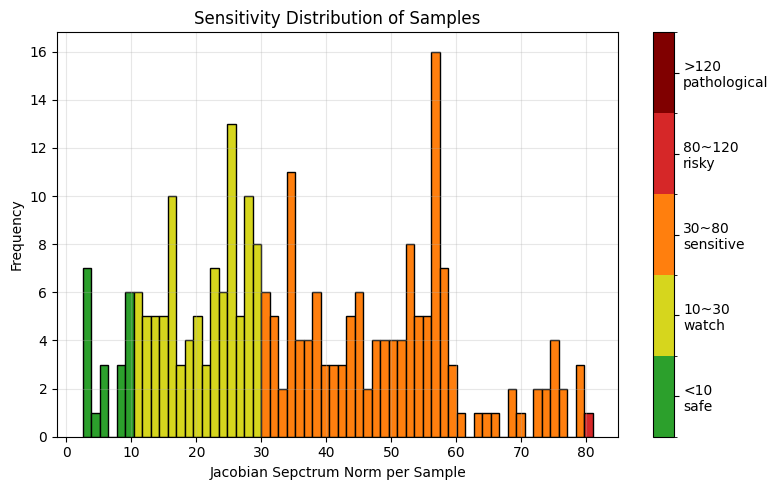

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/NN_training/temp_1/version_1_6/diag_test.csv"
data = pd.read_csv(path)

jac_sigma_max_values = data['jac_sigma_max'].values

# 设定敏感度区间边界
max_val = np.nanmax(jac_sigma_max_values)  # 避免 NaN
bounds = [0, 10, 30, 80, 120, max(max_val + 1, 121)]  # 确保最后一项 >120
labels = ['benign', 'watch', 'sensitive', 'risky', 'pathological']

# 自定义颜色列表（从绿色 → 红 → 深红）
colors = ['#2ca02c', '#d6d61d', '#ff7f0e', '#d62728', '#800000']  # 绿-黄-橙-红-深红
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# 创建图像和坐标轴
fig, ax = plt.subplots(figsize=(8, 5))

# 绘制直方图，获得每个 bin
counts, bins, patches = ax.hist(jac_sigma_max_values, bins=60, edgecolor='black')
ax.grid(alpha = 0.3)

# 为每个 bin 设置颜色：根据 bin 中心值落在哪个区间
for i, patch in enumerate(patches):
    bin_center = 0.5 * (bins[i] + bins[i+1])
    color_idx = np.digitize(bin_center, bounds) - 1  # 获取颜色区间索引
    patch.set_facecolor(cmap(color_idx))

# 添加 colorbar 并自定义标签
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 伪造的 array 仅用于 colorbar 渲染
# 设置 colorbar，刻度在每个区间中点
tick_locs = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
cbar = fig.colorbar(sm, ax=ax, ticks=tick_locs)
cbar.ax.set_yticklabels(['<10\nsafe', '10~30\nwatch', '30~80\nsensitive', '80~120\nrisky', '>120\npathological'])


# 图形设置
ax.set_xlabel('Jacobian Sepctrum Norm per Sample')
ax.set_ylabel('Frequency')
ax.set_title('Sensitivity Distribution of Samples')
plt.savefig("C:\\Users\\97427\\Desktop\\sensitivity_hist.svg", format="svg", bbox_inches="tight")
plt.tight_layout()
plt.show()



C:\Users\97427\AppData\Local\Temp\ipykernel_9648\2496797133.py:27: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\97427\AppData\Local\Temp\ipykernel_9648\2496797133.py:27: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\97427\AppData\Local\Temp\ipykernel_9648\2496797133.py:27: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\97427\AppData\Local\Temp\ipykernel_9648\2496797133.py:27: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


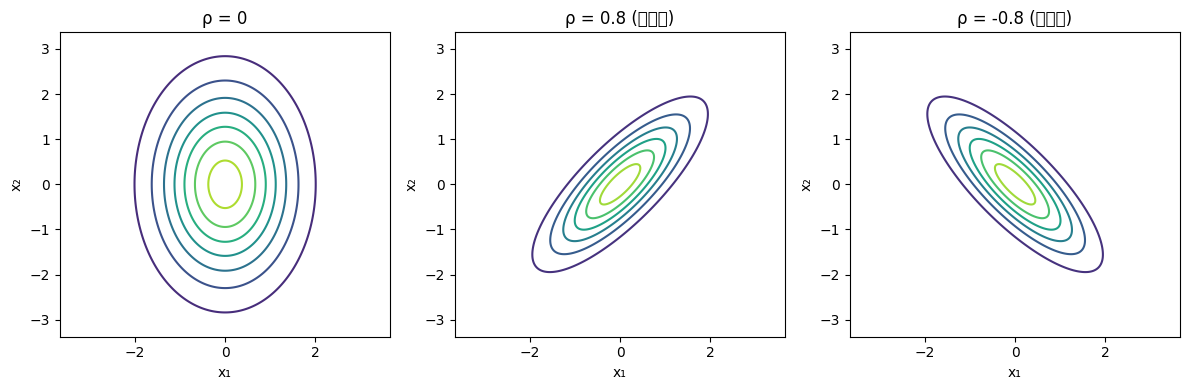

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 网格
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# 参数
mu = np.array([0, 0])
sigmas = [
    np.array([[1.0, 0.0], [0.0, 2.0]]),     # 无相关
    np.array([[1.0, 0.8], [0.8, 1.0]]),     # 正相关
    np.array([[1.0, -0.8], [-0.8, 1.0]])    # 负相关
]
titles = ["ρ = 0", "ρ = 0.8 (正相关)", "ρ = -0.8 (负相关)"]

plt.figure(figsize=(12, 4))
for i in range(3):
    rv = multivariate_normal(mu, sigmas[i])
    plt.subplot(1, 3, i+1)
    plt.contour(x, y, rv.pdf(pos))
    plt.title(titles[i])
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.axis("equal")
plt.tight_layout()
plt.show()


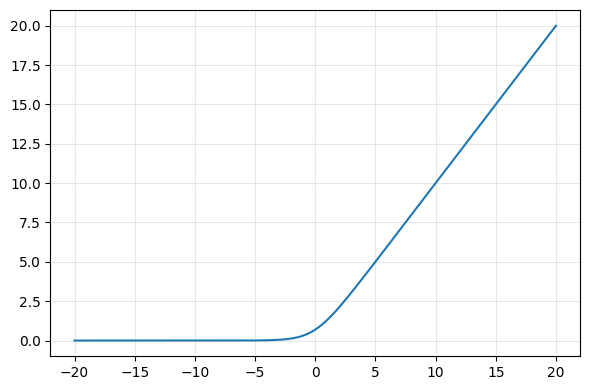

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

x = np.arange(-20,20,0.001)
y = np.log(1+np.exp(x))


plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.grid(True, alpha=0.3)
plt.title('')
plt.tight_layout()
plt.show()

C:\Users\97427\AppData\Local\Temp\ipykernel_8484\1708554650.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


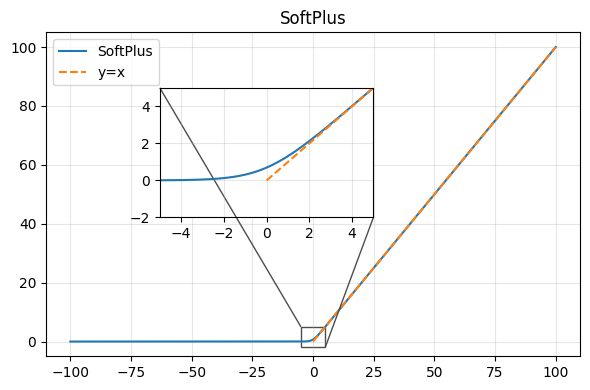

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))

x1 = np.arange(-100,100,0.01)
x2 = np.arange(0,100,0.01)
y1 = np.log(1+np.exp(x1))
y2 = x2

ax.plot(x1, y1, label='SoftPlus')
ax.plot(x2, y2, '--', label='y=x')
ax.set_title('SoftPlus')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')

# 使用 inset_axes 来精确控制位置
axins = inset_axes(ax, width="80%", height="80%", 
                   bbox_to_anchor=(0.2, 0.35, 0.5, 0.5),
                   bbox_transform=ax.transAxes,
                   loc='upper left')

# 画 inset 图
axins.plot(x1, y1)
axins.plot(x2, y2, '--')
axins.set_xlim(-5, 5)
axins.set_ylim(-2, 5)
axins.grid(True, alpha=0.3)

# 添加连接线
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3")

plt.show()
fig.savefig("C:\\Users\\97427\\Desktop\\figure.svg", bbox_inches='tight', format='svg')


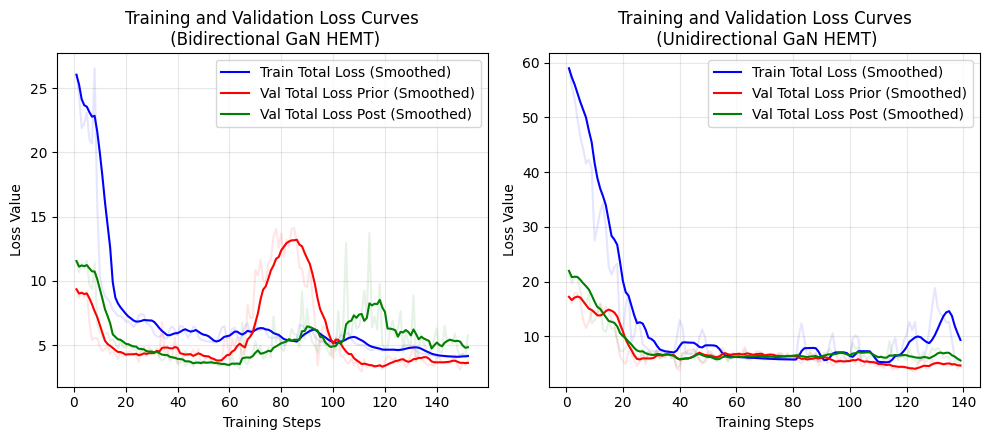

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

uni_file_train_total = "C:\\Users\\97427\\Desktop\\run-version_1_1-tag-train_total.csv"
uni_file_val_prior = "C:\\Users\\97427\\Desktop\\run-version_1_1-tag-val_val_total_prior.csv"
uni_file_val_post = "C:\\Users\\97427\\Desktop\\run-version_1_1-tag-val_val_total_post.csv"

bidi_file_train_total = "C:\\Users\\97427\\Desktop\\run-version_2_15-tag-train_total.csv"
bidi_file_val_prior = "C:\\Users\\97427\\Desktop\\run-version_2_15-tag-val_val_total_prior.csv"
bidi_file_val_post = "C:\\Users\\97427\\Desktop\\run-version_2_15-tag-val_val_total_post.csv"

uni_data_train = pd.read_csv(uni_file_train_total)
uni_data_val_prior = pd.read_csv(uni_file_val_prior)
uni_data_val_post = pd.read_csv(uni_file_val_post)

bidi_data_train = pd.read_csv(bidi_file_train_total)
bidi_data_val_prior = pd.read_csv(bidi_file_val_prior)
bidi_data_val_post = pd.read_csv(bidi_file_val_post)

uni_train_step = uni_data_train['Step'].values
uni_val_step = uni_data_val_prior['Step'].values

bidi_train_step = bidi_data_train['Step'].values
bidi_val_step = bidi_data_val_prior['Step'].values

uni_train_loss = uni_data_train['Value'].values
uni_val_loss_prior = uni_data_val_prior['Value'].values
uni_val_loss_post = uni_data_val_post['Value'].values

bidi_train_loss = bidi_data_train['Value'].values
bidi_val_loss_prior = bidi_data_val_prior['Value'].values
bidi_val_loss_post = bidi_data_val_post['Value'].values

uni_smoothed_train_loss = pd.Series(uni_train_loss).rolling(window=7, min_periods=1).mean()
uni_smoothed_val_loss_prior = pd.Series(uni_val_loss_prior).rolling(window=7, min_periods=1).mean()
uni_smoothed_val_loss_post = pd.Series(uni_val_loss_post).rolling(window=7, min_periods=1).mean()

bidi_smoothed_train_loss = pd.Series(bidi_train_loss).rolling(window=7, min_periods=1).mean()
bidi_smoothed_val_loss_prior = pd.Series(bidi_val_loss_prior).rolling(window=7, min_periods=1).mean()
bidi_smoothed_val_loss_post = pd.Series(bidi_val_loss_post).rolling(window=7, min_periods=1).mean()

fig, ax = plt.subplots(1,2,figsize=(10,4.5))

ax[0].plot(uni_train_step, uni_train_loss, color = 'blue', alpha=0.1)
ax[0].plot(uni_train_step, uni_smoothed_train_loss, label='Train Total Loss (Smoothed)', color = 'blue')
ax[0].plot(uni_val_step, uni_val_loss_prior, color = 'red', alpha=0.1)
ax[0].plot(uni_val_step, uni_smoothed_val_loss_prior, label='Val Total Loss Prior (Smoothed)', color = 'red')   
ax[0].plot(uni_val_step, uni_val_loss_post, color = 'green', alpha=0.1)
ax[0].plot(uni_val_step, uni_smoothed_val_loss_post, label='Val Total Loss Post (Smoothed)', color = 'green')

ax[1].plot(bidi_train_step, bidi_train_loss, color = 'blue', alpha=0.1)
ax[1].plot(bidi_train_step, bidi_smoothed_train_loss, label='Train Total Loss (Smoothed)', color = 'blue')
ax[1].plot(bidi_val_step, bidi_val_loss_prior, color = 'red', alpha=0.1)
ax[1].plot(bidi_val_step, bidi_smoothed_val_loss_prior, label='Val Total Loss Prior (Smoothed)', color = 'red')   
ax[1].plot(bidi_val_step, bidi_val_loss_post, color = 'green', alpha=0.1)
ax[1].plot(bidi_val_step, bidi_smoothed_val_loss_post, label='Val Total Loss Post (Smoothed)', color = 'green')

for i in range(2):
    ax[i].legend()
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel('Training Steps')
    ax[i].set_ylabel('Loss Value')
ax[0].set_title('Training and Validation Loss Curves\n (Bidirectional GaN HEMT)')
ax[1].set_title('Training and Validation Loss Curves\n (Unidirectional GaN HEMT)')


plt.tight_layout()
plt.show()
fig.savefig("C:\\Users\\97427\\Desktop\\figure_loss.svg", bbox_inches='tight', format='svg')

<KeysViewHDF5 ['X_gm', 'X_iv']>
(1, 7, 121)


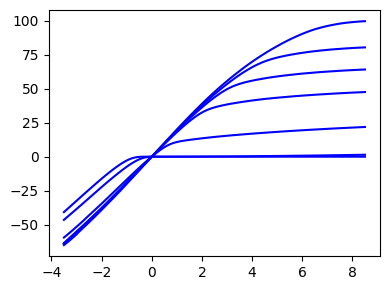

In [47]:
import h5py
from matplotlib import pyplot as plt
import numpy as np

path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/NN_training/dataset/training/meas_smoothed_Uni_2Channel_wide.h5"
fig, ax = plt.subplots(figsize=(4,3))
with h5py.File(path, 'r') as f:
    print(f.keys())
    print(f['X_iv'].shape)
    x = np.linspace(-3.5,8.5,f['X_iv'].shape[2])
    for i in range(f['X_iv'].shape[1]):
        plt.plot(x, f['X_iv'][0,i,:], 'blue')
    plt.tight_layout()
    plt.show()
    fig.savefig("C:\\Users\\97427\\Desktop\\test.svg", bbox_inches='tight', format='svg')

